# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. For some of the more standard plots such as transect contours, I also experiment with my Ocean Toolbox package



In [1]:
# Load Data and relevant modules
%matplotlib inline
import numpy as np
import scipy.signal as sig
from scipy import interpolate
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import cmocean
import pandas as pd
import internal_waves_calculations as iwc
import warnings
import seaborn as sns
import ray_tracing as rt

# Kill warnings (they look ugly but use them while testing new code)
warnings.simplefilter("ignore")

# Allow display of pandas data tables

pd.options.display.max_columns = 22


# Load Data
ladcp, ctd = data_load.load_data()
strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max=1200
wl_min=500
ctd_bin_size=1500
ladcp_bin_size=1500
nfft = 2048
rho0 = 1025


# Extracting Wave Components
This section uses spectral analysis to estimate kinetic and potential energies lee waves. Using a minimum and maximum vertical wavelength as integration limits, I estimate the energetics of target wavelengths. These limits were determined qualitatively by estimative vertical size of features in profiles (how big are the wiggles). 

## Internal Energy
The wave components are estimated through calcuation of the internal wave energy components (Kinetic and Potential). To do this, each profile is seperated into mean and wave-induced perturbations $(X = X + X')$. In order to do this a sliding vertical polynomial is fit to each profile and the resultant profile is subtracted out, leaving the perturbation profile.

### Kinetic Energy
The resultant velocity perturbation profiles (u and v) are binned into 1024 meter, half overlapping bins. The Power Spectral Density is calculated along each being and integrated between a target wavelength band. This band is chosen by examining the perturbation profiles and identifying coherent wave features. The final values are input into the kinetic energy equation. $\langle \rangle$ denotes integrated power spectral density. 

$$ KE = \frac{1}{2}\big[ \langle u'^{2} \rangle + \langle v'^{2} \rangle \big] $$

### Potential Energy 
A similar process is followed for estimating potential energy. However, 2 methods were implemented here, with varying results. The first was to estimate the isopycnal displacement $\eta$ from density perturbations as follows: 

$$\eta = \frac{\rho - \rho_{ref}}{\frac{\Delta \rho_{ref}}{\Delta z}}$$
            
$\rho_{ref}$ is estimated as a transect mean density profile. However, this showed erratic and unrealistic values most likely stemming from how $\frac{d\rho_{ref}}{dz}$ was estimated. The second method utlized the relationship of strain $\xi$ as the vertical gradient of $\eta$. Strain was calculated as

$$ \xi = \frac{N^{2} - {N_{ref}}^2}{{N_{ref}}^2}$$

where $N^2$ is estimated using the adiabtic leveling method derived by Bray and Foffonof(insert year). $N_{ref}^2$ is estimated as the mean N2 profile of the transect. $\xi$ is multipled by the vertical grid spacing of the data, an estimate of $\Delta z$ to obtain $\eta$:

$$ \eta = \xi * \Delta z $$

Once $\eta$ is obtained, the same processes for calculating Power Spectral Density used in kinetic energy calculations are used here with the potential energy equation:

$$ PE = \frac{1}{2}N^2\langle \eta'^{2} \rangle $$

The energy components are combined for the total internal energy $(\frac{J}{m^s})$:

$$ E = \rho(KE + PE) $$

Using the two energy components, the internal wave frequencies are estimated by:

$$ \omega_{0} = f\sqrt{\frac{KE + PE}{KE - PE}}$$

Several other derivations are used and compared with similar results. An issue with this method is that when kinetic and potential energies are similar, error in energy density calculations may cause kinetic energy to be slightly less than potential, resulting in a null value from the square root operation. 
We now have the intrinsic frequency as well as the vertical waveumnber $m$ which is estimated as the mean of integration limits. From here, $k_{h}$, the horizontal wave number is calculated from:

$$  k_{h} = m\sqrt{\frac{f^2 - \omega^2}{\omega^2 - N^2}}$$



In [2]:
# Get Wave parameters using the methods above
PE, KE, omega, m, kh, lambdaH, Etotal,\
    khi, Uprime, Vprime, b_prime, ctd_bins,\
    ladcp_bins, KE_grid, PE_grid, ke_peaks,\
    pe_peaks, dist, depths, KE_psd, eta_psd, N2, N2mean = iwc.wave_components_with_strain(ctd,\
    ladcp, strain, wl_min=wl_min, wl_max=wl_max, plots=False)



# Plot and inspect some of the data

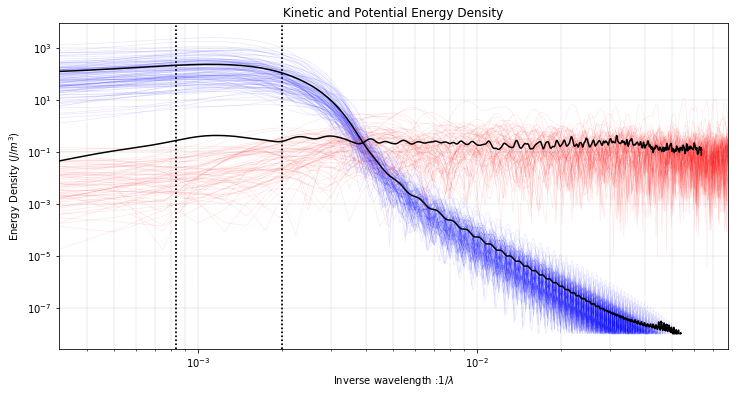

In [3]:
m_plot = np.array([(1)/wl_max,
                   (1)/wl_max, (1)/wl_min,
                   (1)/wl_min])
plt.figure(figsize=[12,6])
plt.loglog(KE_grid, KE_psd.T, linewidth=.6, c='b', alpha=.1)
plt.loglog(KE_grid, np.nanmean(KE_psd, axis=0).T, lw=1.5, c='k')
ylims = plt.gca().get_ylim()
ylim1 = np.array([ylims[0], ylims[1]])
plt.plot(m_plot[2:], ylim1, lw=1.5,
         c='k', alpha=.9,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1.5,
         c='k', alpha=.9,
         linestyle='dotted')
plt.ylim(ylims)
plt.ylabel('Kinetic Energy Density ($J/m^{3}$)')
plt.xlabel('Vertical Wavenumber')
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)

plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T,
           lw=.6, c='r', alpha=.1)
plt.loglog(KE_grid, .5*np.nanmean(N2)*np.nanmean(eta_psd, axis=0).T,
           lw=1.5, c='k')
plt.plot(m_plot[2:], ylim1, lw=1.5,
         c='k', alpha=.9,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1.5,
         c='k', alpha=.9,
         linestyle='dotted')
plt.ylim(ylims)
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)
plt.ylabel('Energy Density ($J/m^{3}$)')
plt.xlabel('Inverse wavelength :$1/\lambda$')
plt.xlim(10**(-3.5), 10**(-1.1))
plt.title('Kinetic and Potential Energy Density')

## Decompose Horizontal Wave Vector
In order to properly run a ray tracing model, the horizontal wavenumber $k_h$ must be decomposed into its two components, $k$ and $l$. The horizontal azimuth, $\theta$, is the angle between the $k_h$ vector and the x-axis. using the relationships:
$$ tan(2\theta) = 2\mathbb{R} \bigg [\frac{u'^{*}v'}{u'u^{*} - v'v^{*}} \bigg ]$$

$$ k = (kh)cos(\theta) $$
$$ l = (kh)sin(\theta) $$

where $*$ represents the complex conjugate and $u'$ and $v'$ represent the Fourier transform of velocity anomalies. 
Fourier transforms are done along the same bins used in the energy calculations. **NOT SO SURE ABOUT HOW RIGHT THIS IS **



In [4]:
# Horizontal wave vector decomposition
k = []
l = []

theta = []
dz = 8

for i in ladcp_bins:
    theta.append(iwc.horizontal_azimuth(Uprime[i,:], Vprime[i,:], dz,\
                                        wl_min=wl_min,
                                        wl_max=wl_max,
                                        nfft=1024))
theta = np.vstack(theta)

k = kh*np.cos(theta)
l = kh*np.sin(theta)

## Inspect wavenumbers in tables - $k_h$

In [5]:
display_table = pd.DataFrame(kh, index=np.squeeze(depths), columns=np.arange(1,22))
cmap = cmap=sns.diverging_palette(250, 5, as_cmap=True)
display_table.style.background_gradient(cmap=cmap, axis=1)\
    .set_properties(**{'max-width': '300px', 'font-size': '12pt'})\
    .set_caption("Horizontal Wavenumber")\
    .set_precision(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,0.000547,0.000601,0.000122,0.000229,0.00092,0.000129,1.99e-06,7.69e-05,0.000196,0.000298,0.00032,0.000183,0.000246,7.63e-05,0.000752,0.00108,0.000784,0.000189,0.00017,0.00018,0.00188
1536.0,0.0029,0.000346,3.99e-05,0.000102,0.00015,0.00012,8.34e-05,0.000495,0.000498,0.000917,0.000156,8.19e-05,0.000237,0.000568,0.000556,0.000737,0.000126,1.95e-05,0.00386,0.00135,0.000365
2048.0,0.000252,1.28e-05,0.000125,0.000712,0.000294,0.000818,0.000165,0.000225,nan,0.00127,0.000429,0.000382,6.36e-05,0.000569,0.000526,0.002,0.002,0.00114,0.000736,0.000496,0.000113
2560.0,0.000112,0.000143,4.79e-05,0.000259,0.000332,0.000843,nan,nan,nan,nan,nan,nan,0.000344,0.00121,nan,nan,nan,nan,nan,nan,0.000186
3072.0,nan,9.72e-05,nan,0.000953,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Inspect wavenumbers in tables - $k$

In [6]:
display_table = pd.DataFrame(k, index=np.squeeze(depths), columns=np.arange(1,22))
display_table.style.background_gradient( axis=1)\
    .set_properties(**{'max-width': '300px', 'font-size': '12pt'})\
    .set_caption("Horizontal Wavenumber $k$")\
    .set_precision(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,0.000397,0.000499,0.000117,0.000228,0.000917,0.000122,1.87e-06,6.21e-05,0.000192,0.000298,0.000263,0.000175,0.000241,6.26e-05,0.0006,0.00108,0.000777,0.000156,0.000145,0.000146,0.00182
1536.0,0.00253,0.000296,3.94e-05,9.45e-05,0.000133,0.000119,6.93e-05,0.000446,0.000497,0.000877,0.000154,6.99e-05,0.000236,0.000556,0.000397,0.000729,0.000126,1.84e-05,0.00282,0.00133,0.000349
2048.0,0.000194,1.27e-05,0.000122,0.000639,0.000266,0.000812,0.000159,0.000202,nan,0.00127,0.000428,0.000287,4.54e-05,0.000567,0.000389,0.0019,0.00166,0.00113,0.000582,0.000495,8.69e-05
2560.0,9.89e-05,0.000138,3.49e-05,0.000259,0.000279,0.000781,nan,nan,nan,nan,nan,nan,0.000338,0.000946,nan,nan,nan,nan,nan,nan,0.000186
3072.0,nan,8.18e-05,nan,0.000843,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Inspect wavenumbers in tables - $l$

In [7]:
display_table = pd.DataFrame(l, index=np.squeeze(depths), columns=np.arange(1,22))
display_table.style.background_gradient(cmap=cmap, axis=1)\
    .set_properties(**{'max-width': '300px', 'font-size': '12pt'})\
    .set_caption("Horizontal Wavenumber $l$")\
    .set_precision(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,0.000376,0.000334,3.74e-05,-2.19e-05,-7.56e-05,-4.04e-05,6.58e-07,4.53e-05,-3.96e-05,1.02e-05,0.000183,5.4e-05,5.16e-05,4.36e-05,0.000453,-5.67e-05,-0.000108,0.000106,-8.93e-05,0.000104,-0.000501
1536.0,-0.00143,0.000179,-6.72e-06,-3.91e-05,6.96e-05,-1.05e-05,4.65e-05,0.000214,-3.77e-05,-0.000269,2.42e-05,4.27e-05,1.55e-05,0.000119,0.00039,-0.000106,6.87e-06,-6.45e-06,0.00263,0.000247,0.000109
2048.0,0.000161,-1.59e-06,-2.49e-05,0.000316,-0.000125,-9.57e-05,4.57e-05,-9.89e-05,nan,-9.17e-05,-2.48e-05,-0.000253,-4.46e-05,4.18e-05,0.000355,0.000617,0.00111,5.47e-05,0.000449,-2.05e-05,-7.28e-05
2560.0,5.2e-05,3.74e-05,3.28e-05,2.45e-06,-0.00018,-0.000316,nan,nan,nan,nan,nan,nan,-6.49e-05,0.000749,nan,nan,nan,nan,nan,nan,5.51e-07
3072.0,nan,-5.24e-05,nan,0.000445,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Inspect Frequency $\omega_0$

In [8]:
display_table = pd.DataFrame(omega, index=np.squeeze(depths), columns=np.arange(1,22))
display_table.style.background_gradient(cmap=cmap, axis=1)\
    .set_properties(**{'max-width': '300px', 'font-size': '12pt'})\
    .set_caption("Horizontal Wavenumber $l$")\
    .set_precision(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
512.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1024.0,-0.000221,-0.000161,-0.000121,-0.000125,-0.000192,-0.00012,-0.000117,-0.000118,-0.00012,nan,-0.000136,-0.000129,-0.000136,-0.00012,-0.000282,nan,-0.00019,-0.000133,-0.000126,-0.000137,nan
1536.0,-0.000501,-0.000132,-0.000117,-0.000119,-0.000121,-0.000127,-0.000118,-0.000175,-0.000146,-0.000183,-0.000121,-0.000119,-0.000131,-0.000161,-0.000159,-0.000191,-0.00012,-0.000137,nan,-0.000208,-0.000169
2048.0,-0.000124,-0.000123,-0.000119,-0.000159,-0.000127,-0.000147,-0.000119,-0.000123,nan,-0.000185,-0.000143,-0.000147,-0.000226,-0.000155,-0.000154,nan,nan,-0.000258,nan,-0.000147,-0.000136
2560.0,-0.000118,-0.000119,-0.000117,-0.000123,-0.000128,-0.000212,nan,nan,nan,nan,nan,nan,-0.00015,-0.000176,nan,nan,nan,nan,nan,nan,-0.000133
3072.0,nan,-0.000118,nan,-0.000167,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [22]:
std = np.nanstd(omega.flatten())

In [24]:
mean = np.nanmean(omega.flatten())

In [27]:
S, T, P, lat, lon = oc.loadCTD(ctd)
f = np.nanmean(gsw.f(lat))



(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   4.,  13.,  46.]),
 array([-0.00050052, -0.00046218, -0.00042383, -0.00038548, -0.00034713,
        -0.00030879, -0.00027044, -0.00023209, -0.00019375, -0.0001554 ,
        -0.00011705]),
 <a list of 10 Patch objects>)

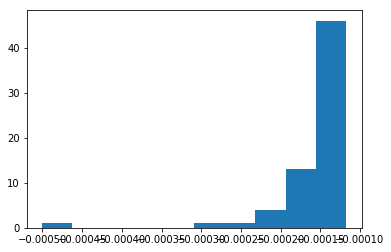

In [20]:
plt.hist(omega.flatten(), bins=10, range=(np.nanmin(omega), np.nanmax(omega)))

In [21]:
-0.00015293408269703877 -5.5848191654506425e-05

-0.0002087822743515452

In [34]:
limits = [mean-std,f]

mask = np.isfinite(omega)
test = np.logical_and(omega[mask].flatten() <= limits[1],  omega[mask].flatten() >= limits[0])

In [37]:
sum(test) / len(omega[mask].flatten())


0.90909090909090906

In [38]:
std/f

-0.47786661097617111

In [39]:
f

-0.00011686983432556936

In [41]:
print(-1e-4)
print(f)


-0.0001
-0.000116869834326
